#Llama-3.2-3b Model Evaluation

<hr> <hr>


### Installing Required Libraries
This cell installs the libraries necessary for model evaluation, such as `datasets`, `transformers`, and `evaluate`.
Ensure that you have an active internet connection while running this cell.


In [ ]:
%%capture
!pip install datasets
!pip install bitsandbytes peft trl accelerate transformers huggingface_hub
!pip install evaluate
!pip install sacrebleu rouge_score jiwer cer

## Importing Model from Huggingface Hub


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name ="roger33303/llama3.2-3b-Instruct-Finetune-website-QnA"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,device_map="cuda:0")

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/994 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

## Testing Model

In [ ]:
from transformers import TextStreamer
def chatml(question,model):
    messages = [{"role": "user", "content": question},]

    inputs = tokenizer.apply_chat_template(messages,
                                           tokenize = True,
                                           add_generation_prompt = True,
                                           return_tensors = "pt",).to("cuda")

    print(tokenizer.decode(inputs[0]))
    text_streamer = TextStreamer(tokenizer,skip_special_tokens=True,
                                 skip_prompt=True)
    return model.generate(input_ids = inputs,
                          streamer = text_streamer,
                          max_new_tokens = 512,

                          )

In [ ]:
question = "Does the University of Westminster offer a course on AI, Data and Communication MA?"
x = chatml(question,model)

Yes, University of Westminster provides a course on AI, Data and Communication MA:
Course title: AI, Data and Communication MA.
Campus: Cavendish, Central London.
For full-time course:
UK fees:£9,700.
international fees: £17,500.
The duration of the course is 1 year.
For more details please visit the official website: https://www.westminster.ac.uk/computer-science-and-engineering-courses/2025-26/september/full-time/ai-data-and-communication-ma
For Part-time course:
UK fees: £1,125.
international fees: £1,985.
The duration of the course is 2 years.
For more details please visit the official website: https://www.westminster.ac.uk/computer-science-and-engineering-courses/2025-26/september/part-time-day/ai-data-and-communication-ma 


## Evaluating Model Performance


In [ ]:
import torch
from datasets import Dataset, load_dataset
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm
import pandas as pd

In [ ]:
eval_data = load_dataset("csv", data_files='/content/drive/MyDrive/msc_project/llama_test_data.csv', split='train')

In [ ]:
# conv = []
# for i in range(len(eval_data['conversations'])):
#     a = eval_data['conversations'][0].partition('{')[-1].partition('{')[-1]
#     a = a.partition(':')[-1].partition('role')[0]
#     a=a.replace("\\n","\n")
#     conv.append(a[2:-5])

# ques = []
# for i in range(len(eval_data['conversations'])):
#     a = eval_data['conversations'][0].partition("', 'role': 'user'}")[0].partition("[{'content': '")[-1]
#     ques.append(a)

# eval_data = eval_data.add_column("y_true", conv)
# eval_data = eval_data.add_column("question", ques)

## Loading test dataset and formating it and generating output from llm for evaluation

In [ ]:
y_true =[]
y_pred=[]
model.eval()
eval_loader = DataLoader(eval_data, batch_size=1, shuffle=False)
for batch in tqdm(eval_loader):
        query = batch["y_true"][0]
        y_true.append(query)
        question = batch["question"][0]
        messages = [{"role": "user", "content": question},]
        inputs = tokenizer.apply_chat_template(messages,tokenize = True, add_generation_prompt = False,return_tensors = "pt",).to("cuda")
        outputs = model.generate(input_ids = inputs, max_new_tokens = 512)
        generated_text= tokenizer.batch_decode(outputs,skip_special_tokens=True,skip_prompt=True )
        txt = generated_text[0]
        txt = txt.partition("assistant\n\n")[-1].strip()
        y_pred.append(txt)


100%|██████████| 69/69 [06:39<00:00,  5.78s/it]


In [ ]:
llama_y_pred_y_test = pd.DataFrame({"y_pred":y_pred,"y_test":y_true})

In [ ]:
llama_y_pred_y_test.to_csv("/content/drive/MyDrive/msc_project/llama_y_pred_y_test.csv",index=False)

# Evaluation

In [ ]:
from datasets import Dataset, load_dataset
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import pandas as pd
import evaluate
llama_y_pred_y_test = pd.read_csv("/content/drive/MyDrive/msc_project/llama_y_pred_y_test.csv")

y_pred  = llama_y_pred_y_test["y_pred"].tolist()
y_true = llama_y_pred_y_test["y_test"].tolist()

sacrebleu = evaluate.load("sacrebleu")
results = sacrebleu.compute(predictions=y_pred, references=y_true)
results['score']

85.97931887799939

In [ ]:
scoreboard = {}
scoreboard.update({'bleu_score':results['score']})

## CER Score

In [ ]:
exact_match_metric = evaluate.load("character")
results2 = exact_match_metric.compute(predictions=y_pred, references=y_true)
results2

{'cer_score': 0.1379345620399138}

## Meteor Score

In [ ]:
meteor = evaluate.load('meteor')
result3 = meteor.compute(predictions=y_pred, references=y_true)
result3

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


{'meteor': 0.9036065763771711}

## Rouge Score

In [ ]:
rouge = evaluate.load('rouge')
result4 = rouge.compute(predictions=y_pred, references=y_true)
result4

{'rouge1': 0.9047332338732584,
 'rouge2': 0.8678806228121435,
 'rougeL': 0.9052760461068475,
 'rougeLsum': 0.9040838572747931}

In [ ]:
scoreboard.update(results2)
scoreboard.update(result3)
scoreboard.update(result4)
scoreboard.update({'model':'llama'})

In [ ]:
scoreboard

{'bleu_score': 85.97931887799939,
 'cer_score': 0.1379345620399138,
 'meteor': 0.9036065763771711,
 'rouge1': 0.9047332338732584,
 'rouge2': 0.8678806228121435,
 'rougeL': 0.9052760461068475,
 'rougeLsum': 0.9040838572747931,
 'model': 'llama'}

In [ ]:
x = pd.DataFrame.from_dict([scoreboard])

In [ ]:
x

,bleu_score,cer_score,meteor,rouge1,rouge2,rougeL,rougeLsum,model
0,85.979319,0.137935,0.903607,0.904733,0.867881,0.905276,0.904084,llama


## Saving Score Data

In [ ]:
import pandas as pd
try:
    df = pd.read_csv("/content/drive/MyDrive/msc_project/model_results.csv")
    df = pd.concat([df,x])
    df.reset_index(drop=True, inplace=True)
    df.to_csv("/content/drive/MyDrive/msc_project/model_results.csv",index=False)
except:
    x.to_csv("/content/drive/MyDrive/msc_project/model_results.csv",index=False)
finally:
    df = pd.read_csv("/content/drive/MyDrive/msc_project/model_results.csv")

In [ ]:
df

,bleu_score,cer_score,meteor,rouge1,rouge2,rougeL,rougeLsum,model
0,49.938569,0.450135,0.796419,0.694390,0.654254,0.686169,0.692310,gemma
1,76.661574,0.234241,0.807951,0.879088,0.815652,0.872806,0.878410,mistral
2,85.979319,0.137935,0.903607,0.904733,0.867881,0.905276,0.904084,llama


## Visualizations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_theme(style="whitegrid")
sns.set_context("notebook")
sns.set_palette('dark')

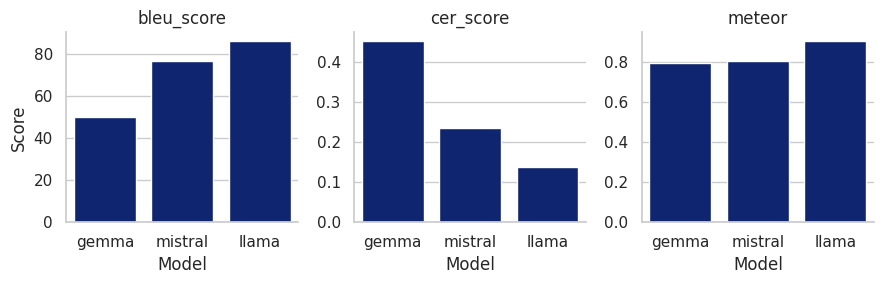

In [ ]:
df_melted = df.melt(id_vars="model",
                    value_vars=["bleu_score", "cer_score", "meteor",],
                    var_name="metric",
                    value_name="score")

g = sns.FacetGrid(df_melted, col="metric", col_wrap=3, height=3,sharey=False)
g.map(sns.barplot, "model", "score", order=df["model"].unique())
g.set_titles("{col_name}")
g.set_axis_labels("Model", "Score")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)

plt.tight_layout()
plt.show()
